# Vectorize cBoW
<div style="position: absolute; right:0;top:0"><a href="./vectorizer_index.doc.ipynb" style="text-decoration: none"> <font size="5">←</font></a>
<a href="../evaluation.ipynb" style="text-decoration: none"> <font size="5">↑</font></a></div>

`Description`

---
## Setup and Settings
---

In [1]:
from __init__ import init_vars
init_vars(vars(), ('info', {}), ('runvars', {}), ('num_docs', 400))

import numpy as np
from scipy import sparse

import data
import config
from base import nbprint
from util import ProgressIterator
from widgetbase import nbbox

from embedding.main import get_model

from vectorizer.widgets import cbow_vector_picker
from vectorizer.plots import plot_matrix
from vectorizer.vectorize_bow import make_term_doc_mat_count, make_term_doc_mat_tf_idf

if RUN_SCRIPT: cbow_vector_picker(info)

Data Name,ACM (exists)
Token Version,Cw2v (exists)
Vocab Version,C0 (exists)
Vector,exists
Version,C0
Type,TfIdf
TF,normalized
IDF,unary


FloatProgress(value=0.0, bar_style='info', layout=Layout(visibility='hidden'), max=1.0, style=ProgressStyle(de…

---
## Count
---

Count matrix is the base for all further types. Take function `make_term_doc_mat_count()` from [Vectorize BoW](./vectorize_bow.ipynb#Count-Tokens-and-build-matrix)

In [2]:
if RUN_SCRIPT:
    nbbox(mini=True)
    make_term_doc_mat_count(info, runvars)


Documents 36395, Excluded 1 empty documents  


FloatProgress(value=0.0, bar_style='info', layout=Layout(visibility='hidden'), max=1.0, style=ProgressStyle(de…

---
## Tf-Idf
---
This matrix can be computed by multiplying the embedding matrix $V$, where each column is the wordembedding vector of the corresponding word, with the standard BoW tf-idf matrix $X$. $X$ is computed using the `make_term_doc_mat_tf_idf()` function from [Vectorize BoW](./vectorize_bow.ipynb#Build-complete-tokenizer-function). Note that $V$ will not be explicitly computed.

In [ ]:
def make_cbow_mat_tf_idf(info, runvars):
    # Create tf-idf matrix
    make_term_doc_mat_tf_idf(info, runvars)
    tf_idf_mat = runvars['term_doc_mat_tf_idf']
    
    # Load vocabulary and wordembedding vectors
    vocab_list = data.load_vocab_list(info)
    model = get_model(info)
    embeddings = model.get_embeddings()
    
    # Create a zero matrix
    cbow_tf_idf_shape = (model.vector_size(), tf_idf_mat.shape[1])
    cbow_tf_idf = np.zeros(cbow_tf_idf_shape)
    
    # Iterate over all nonzero entries of the tf-idf matrix:
    nonzeros = zip(*sparse.find(tf_idf_mat))
    for token_idx, doc_idx, value in ProgressIterator(nonzeros, length = tf_idf_mat.nnz, print_every = 5000):
        # Add each entry times the corresponding vector to the matrix
        try:
            cbow_tf_idf[:,doc_idx] = cbow_tf_idf[:,doc_idx] + value * embeddings[vocab_list[token_idx]]
        except KeyError:
            continue
        
    # Return the matrix
    runvars['cbow_mat'] = cbow_tf_idf

if RUN_SCRIPT and info['vector_info']['type'] == 'TfIdf':
    nbbox(mini=True)
    make_cbow_mat_tf_idf(info, runvars)
    plot_matrix(runvars['cbow_mat'][:,1:num_docs])


Loading embedding model...  


FloatProgress(value=0.0, bar_style='info', layout=Layout(visibility='hidden'), max=1.0, style=ProgressStyle(de…

---
## MinMaxMean
---
The MinMaxMean vector $x_i$ of a document is defined as $x_i = (x_i^{min}, x_i^{max}, x_i^{mean})^T$ with

$$x_i^{min} = \min (\{v_j \, \vert \, \forall \, \text{tokens } j \in \text{document } i\}),$$  
$$x_i^{max} = \max (\{v_j \, \vert \, \forall \, \text{tokens } j \in \text{document } i\}),$$  
$$x_i^{mean} = \frac{1}{\text{number of tokens}} \sum_j v_j,$$  
where $\min$ and $\max$ are defined entry wise.

In [7]:
def make_cbow_mat_minmaxmean(info, runvars):
    # Get count matrix
    count_mat = runvars['term_doc_mat_count']
    
    # Load vocabulary and wordembedding vectors
    vocab_list = data.load_vocab_list(info)
    model = get_model(info)
    embeddings = model.get_embeddings()
    
    # Create a zero matrix
    cbow_m_shape = (model.vector_size(), count_mat.shape[1])
    cbow_min = np.full(cbow_m_shape, np.inf)
    cbow_max = np.full(cbow_m_shape, -np.inf)
    cbow_mean = np.zeros(cbow_m_shape)
    column_sum = np.zeros(count_mat.shape[1])
    
    # Iterate over all nonzero entries of the count matrix:
    nonzeros = zip(*sparse.find(count_mat))
    for token_idx, doc_idx, value in ProgressIterator(nonzeros, length = count_mat.nnz, print_every = 5000):
        try:
            embedding_vector = embeddings[vocab_list[token_idx]]
        except KeyError:
            continue
        # Entry wise minimum with the embedding vector
        cbow_min[:,doc_idx] = np.minimum(cbow_min[:,doc_idx], embedding_vector)
        # Entry wise maximum with the embedding vector
        cbow_max[:,doc_idx] = np.maximum(cbow_max[:,doc_idx], embedding_vector)
        # Sum up all embedding vectors and the total number of tokens in the document
        cbow_mean[:,doc_idx] = cbow_mean[:,doc_idx] + value * embedding_vector
        column_sum[doc_idx] = column_sum[doc_idx] + value
        
    # Divide sum by number of tokens
    cbow_mean = cbow_mean * sparse.diags(1/np.maximum(1, column_sum))
    
    # Stack all matrices and return
    cbow_mat = np.vstack((cbow_min,cbow_max,cbow_mean))
    cbow_mat[np.invert(np.isfinite(cbow_mat))] = 0
    runvars['cbow_mat'] = cbow_mat

if RUN_SCRIPT and info['vector_info']['type'] == 'MinMaxMean':
    nbbox(mini=True)
    make_cbow_mat_minmaxmean(info, runvars)
    plot_matrix(runvars['cbow_mat'][:,1:num_docs])

---
## Fisher Vector
---
Compute mean and variance of all vectors in the vocabulary

In [16]:
def fv_mean_var_vectors(info, runvars):
    # Load vocabulary and wordembedding vectors
    vocab_list = data.load_vocab_list(info)
    model = get_model(info)
    embeddings = model.get_embeddings()
    
    # Sum to compute mean
    mean_vec = 0
    count = 0
    for token in vocab_list:
        try:
            mean_vec += embeddings[token] 
        except KeyError:
            continue
        count += 1
    mean_vec /= count
    runvars['mean_vec'] = mean_vec
    
    # Sum to compute variance
    var_vec = 0
    for token in vocab_list:
        try:
            var_vec += np.square(embeddings[token] - mean_vec)
        except KeyError:
            continue
    var_vec /= count
    runvars['var_vec'] = np.maximum(0.001, var_vec)

if RUN_SCRIPT and info['vector_info']['type'] == 'FV':
    nbbox(mini=True)
    fv_mean_var_vectors(info, runvars)
    nbprint('Mean: {}...'.format(runvars['mean_vec'][:10]))
    nbprint('Variance: {}...'.format(runvars['var_vec'][:10]))


Mean: [ 0.01027701 -0.03263787  0.00808238  0.06478012 -0.04960066  0.01255979
 -0.00518904 -0.02604025  0.0119805   0.06604103]...  

Variance: [0.02442718 0.02551291 0.02314804 0.02207162 0.02387691 0.02327472
 0.02660999 0.02343317 0.03017877 0.02398627]...  


FloatProgress(value=0.0, bar_style='info', layout=Layout(visibility='hidden'), max=1.0, style=ProgressStyle(de…

Build the FVs

FloatProgress(value=0.0, bar_style='info', layout=Layout(visibility='hidden'), max=1.0, style=ProgressStyle(de…

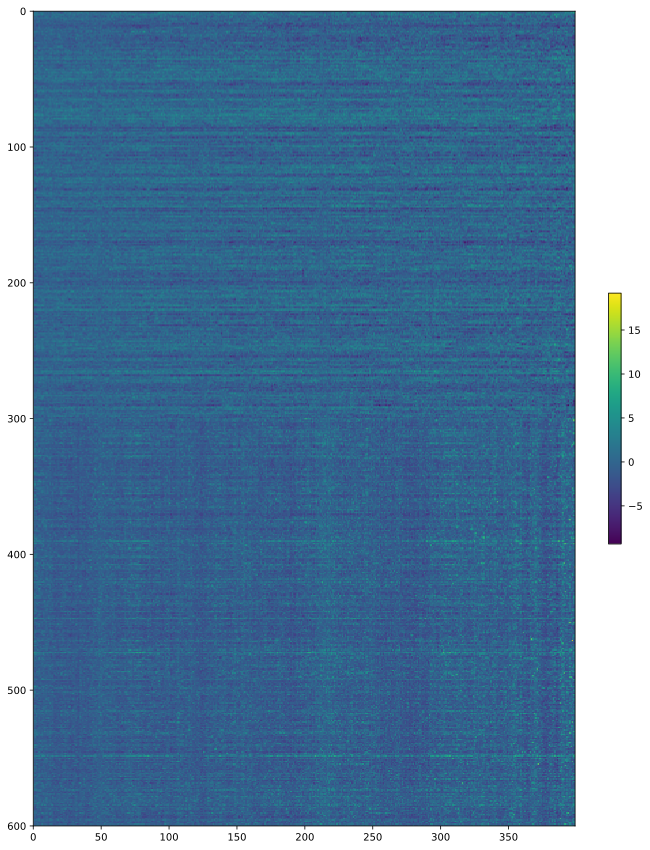

In [41]:
def fv_make_matrix(info, runvars):
    # Get matrices
    count_mat = runvars['term_doc_mat_count']
    mean_vec = runvars['mean_vec']
    var_vec = runvars['var_vec']
    
    # Load vocabulary and wordembedding vectors
    vocab_list = data.load_vocab_list(info)
    model = get_model(info)
    embeddings = model.get_embeddings()
    
    # Create a zero matrix
    dimension = model.vector_size()
    fv_m_shape = (model.vector_size()*2, count_mat.shape[1])
    fv_mat = np.zeros(fv_m_shape)
    fv_num_tokens_shape = (1, count_mat.shape[1])
    fv_num_tokens = np.zeros(fv_num_tokens_shape)
    
    # iterate all nonzero entries
    nonzeros = zip(*sparse.find(count_mat))
    for token_idx, doc_idx, value in ProgressIterator(nonzeros, length = count_mat.nnz, print_every = 5000):
        try:
            embedding_vector = embeddings[vocab_list[token_idx]]
        except KeyError:
            continue
        fv_mat[:dimension, doc_idx] += value * (embedding_vector - mean_vec) / var_vec
        fv_mat[dimension:, doc_idx] += value * (np.square(embedding_vector - mean_vec) / (var_vec * np.sqrt(var_vec)) - (1 / np.sqrt(var_vec)))
        fv_num_tokens[0,doc_idx] += value
        
    # normalize
    fv_num_tokens[fv_num_tokens == 0] = 1
    fv_mat *= np.power(fv_num_tokens, -0.5)
    fv_mat[:dimension,:] = (fv_mat[:dimension,:].transpose() * np.nan_to_num(np.power(1 / var_vec, -0.5))).transpose()
    fv_mat[dimension:,:] = (fv_mat[dimension:,:].transpose() * np.nan_to_num(np.power(2 / var_vec, -0.5))).transpose()
        
    runvars['cbow_mat'] = fv_mat
    
if RUN_SCRIPT and info['vector_info']['type'] == 'FV':
    nbbox(mini=True)
    fv_make_matrix(info, runvars)
    plot_matrix(runvars['cbow_mat'][:,1:num_docs])

Build complete function

In [ ]:
def make_cbow_fv(info, runvars):
    fv_mean_var_vectors(info, runvars)
    fv_make_matrix(info, runvars)